## Summary  

We tested four methods to convert the textual contents to vectors in numbers, and the optimal solution results for each are:  
1. Bag-of-words
   * Configuration: min_occurane=0, learning_rate=0.9, no momentum
   * Test Loss: 0.6367, Test Acc: 0.7293
2. Word-based N-gram
   * Configuration: n=[1,2], min_occurane=1, learning_rate=0.9, momentum=0.3
   * Test Loss: 0.6434, Test Acc: 0.7327
3. Character-based N-gram
   * Configuration: n=[3,4], min_occurane=0, learning_rate=0.1, momentum=0.1
   * Test Loss: 0.6520, Test Acc: 0.7276
4. Pre-trained Word2Vec
   * Configuration: model=”glove-wiki-gigaword-300”, learning_rate=0.95, momentum=0.9
   * Test Loss: 0.5654, Test Acc: 0.7597
  
The pre-trained model has provided the most accurate classification with the shortest time cost. The advantages of using pre-trained models include the ability to leverage the knowledge and experience of others, the ability to save time and resources, and the ability to improve model performance.  

Word-based n-gram has the second best performance, whilst the byte-based n-gram has the worst performance. Byte-based n-grams usually require less memory to hold the vocabularies, and hold much less information. The limited vocabulary size leads to easy-overfitting and low generalization easily. Byte-based n-grams are usually utilized in such tasks as language identification, writer identification (i.e. fingerprinting), anomaly detection. This is why it does not have good performances here, since it is not suitable for the classification task for sentiment mining.   

BOW is weaker than word-based n-grams, but better than the character-based ngrams. During the NLP application, n-gram is used to consider words in their real order so we can get an idea about the context of the particular word; BOW is used to build vocabulary for your text dataset. An assumption is that the word order and word-probability in regards to another word is important to our task, especially when the data itself has objectives such as the nature of reviews or comments. That is, for example, “he likes chocolate but hates vanilla” and  “he likes vanilla but hates chocolate” have completely different meanings, but this type of difference can not be interpolated by BOW models.  

Our current weight calculation when vectorizing texts is purely based on the occurrence count of a word. If time applies, we could try comparing TF-IDF for feature extraction, since TF-IDF not only focuses on the frequency of words present in the corpus but also provides the importance of the words. 

In [2]:
import os, random, operator, sys
from collections import Counter
import random
import collections
import math
import sys
import time
import numpy as np

from string import punctuation
import matplotlib.pyplot as plt

np.set_printoptions(threshold=np.inf)

In [3]:
def dotProduct(d1, d2):
    """
    @param dict d1: a feature vector represented by a mapping from a feature (string) to a weight (float).
    @param dict d2: same as d1
    @return float: the dot product between d1 and d2
    """
    if len(d1) < len(d2):
        return dotProduct(d2, d1)
    else:
        return sum(d1.get(f, 0) * v for f, v in d2.items())


In [4]:
def increment(d1, scale, d2):
    """
    Implements d1 += scale * d2 for sparse vectors.
    @param dict d1: the feature vector which is mutated.
    @param float scale
    @param dict d2: a feature vector.
    """
    for f, v in d2.items():
        d1[f] = d1.get(f, 0) + v * scale


In [5]:
def readExamples(path):
    '''
    读取数据
    '''
    examples = []
    for line in open(path, encoding = "ISO-8859-1"):
        # Format of each line: <output label (+1 or -1)> <input sentence>
        y, x = line.split(' ', 1)
        # cleaning up texts
        x = cleanUpText(x)
        examples.append((x.strip(), int(y)))
    print('Read %d examples from %s' % (len(examples), path))
    return examples


In [6]:
def evaluatePredictor(examples, predictor):
    '''
    在|examples|上测试|predictor|的性能，返回错误率
    '''
    error = 0
    for x, y in examples:
        if predictor(x) != y:
            error += 1
    return 1.0 * error / len(examples)

In [7]:
"""
In the topical classification of text, stemming as well as the removal of stop words and punctuation marks are usually applied to reduce the feature size and improve the classification accuracy. However, punctuation marks and stop words may be important in sentiment analysis, as they can be used to express sentiments.  
ref: https://medium.com/@wila.me/preprocessing-text-for-sentiment-analysis-36a9296aa9e5  
In addition, since upper-case characters can suggest strong emotions, we will only convert the start word of each line to lower cases. 
"""

def cleanUpText(text):
    """
    convert the start word of each line to lower case
    
    text (str): text to be cleaned
    """
    tokens = text.split(" ")
    tokens[0] = tokens[0].lower()
    return " ".join(tokens)

## 1 Read Data

In [8]:
train_data = readExamples('./data/data_rt.train')
test_data = readExamples('./data/data_rt.test')

Read 3554 examples from ./data/data_rt.train
Read 3554 examples from ./data/data_rt.test


## 2 Extract Features

### 2.1 Bag-of-Words(Count Vectorize)

In [9]:
def build_vocab(data, min_occurane=500):
    """
    Build vocab from train data

    min_occurane: remove low frequency word
    """
    vocab_counter = Counter()
    for (line, label) in data:
        tokens = line.split(" ")
        vocab_counter.update(tokens)

    vocab = [word for word, count in vocab_counter.items() if count>min_occurane]

    # add <UNK> as a pad token for word not in the vocab
    vocab.insert(0, '<UNK>')

    return vocab

In [10]:
def BOW_feature_extract(x, vocab):
    # initialize all zero array to hold the weight of tokens in the vocab
    vectorize = np.zeros((len(vocab),), dtype=float)

    # count word frequency and update the vectorization
    words = x.split(" ")
    for word in words:
        if word in vocab:
            vectorize[vocab.index(word)] += 1
        else:
            # <UNK> is always the first word in the vocabulary
            vectorize[0] += 1
    # normalization
    sum = vectorize.sum(axis=0)
    if sum!=.0:
        vectorize = vectorize / sum
    return vectorize
    

### 2.2 N-Gram

In [11]:
def build_ngrams(data, ngram=[2], min_occurane=500, byte_base=False):
    """
    n-gram: list(int), supports multiple n-gram mixing
    byte_base: character-based n-gram or word-based n-gram
    """
    ngram_counter = Counter()

    # word-based
    if not byte_base:
        for (line, label) in data:
            words = line.split(" ")
            for ngram_v in ngram:
                if ngram_v>1:
                    words.insert(0, '<PAD>')
                    words.insert(-1, '<PAD>')
                temp = zip(*[words[i:] for i in range(ngram_v)])
                ngram_tokens = [' '.join(ngram) for ngram in temp]
                ngram_counter.update(ngram_tokens)
    # character-based
    else:
        for (line, label) in data:
            for ngram_v in ngram:
                temp = zip(*[line[i:] for i in range(ngram_v)])
                ngram_tokens = [' '.join(ngram) for ngram in temp]
                ngram_tokens = ['<PAD>'+line[0], line[-1]+'<PAD>'] + ngram_tokens
                ngram_counter.update(ngram_tokens)

    
    ngrams = [word for word, count in ngram_counter.items() if count>min_occurane]

    # add <UNK>, <PAD> as a pad token for word not in the vocab or padding to the start/end word in a line
    ngrams.insert(0, '<UNK>')

    return ngrams

In [12]:
def Ngram_feature_extract(x, ngrams, ngram=[2], byte_base=False):
    # initialize all zero array to hold the weight of tokens in the vocab
    vectorize = np.zeros((len(ngrams),), dtype=float)

    # count word frequency and update the vectorization

    # if is word-based
    if not byte_base:
        words = x.split(" ")
        for ngram_v in ngram:
            if ngram_v>1:
                words.insert(0, '<PAD>')
                words.insert(-1, '<PAD>')
            temp = zip(*[words[i:] for i in range(ngram_v)])
            tokens = [' '.join(ngram) for ngram in temp]

            for token in tokens:
                if token in ngrams:
                    vectorize[ngrams.index(token)] += 1
                else:
                    # <UNK> is always the first word in the vocabulary
                    vectorize[0] += 1
                    
    # if is character based
    else:
        for ngram_v in ngram:
            temp = zip(*[line[i:] for i in range(ngram_v)])
            tokens = [' '.join(ngram) for ngram in temp]
            tokens = ['<PAD>'+line[0], line[-1]+'<PAD>'] + tokens

            for token in tokens:
                if token in ngrams:
                    vectorize[ngrams.index(token)] += 1
                else:
                    # <UNK> is always the first word in the vocabulary
                    vectorize[0] += 1

    # normalization
    sum = vectorize.sum(axis=0)
    if sum!=.0:
        vectorize = vectorize / sum
        
    return vectorize

### 2.3 Pre-trained Word2Vec  

Code inspired by below references --  

ref: https://udai.gitbook.io/practical-ml/natural-language-processing/basics-of-nlp-and-feature-extraction-methods/feature-extraction-methods-word2vec   
ref: https://blog.csdn.net/KPer_Yang/article/details/127353301  

https://stackoverflow.com/questions/75023586/word2vec-object-has-no-attribute-infer-vector   

Word2Vec, is a model only for learning vectors for individual words. As an algorithm, word2vec says nothing about what a vector for a multi-word text should be.  
Many people choose to use the average of all a multi-word text's individual words as a simple vector for the text as a whole. It's quick & easy to calculate, but fairly limited in its power. Still, for some applications, especially broad topical-classifications that don't rely on any sort of grammatical/ordering understanding, such text-vectors work OK – especially as a starting baseline against which to compare additional techniques.   

An optimization for the limitation stated above could be the doc2vec model. However, due to the limitation of time, we will not test this model.  

In this section, we will focus on the pretrained <b>"glove-wiki-gigaword"</b> with difference embed dimensions.

In [13]:
import gensim.downloader as api
import gensim

In [14]:
def pretrain_extract_features(x, model):
    """
    model : pretrained model
    Pretrained model list could be found at: https://radimrehurek.com/gensim/models/word2vec.html
    """

    # clean up texts (all lower case)
    word_list = x.lower().split(" ")
    multiword_average_vector = model.get_mean_vector(word_list)
    return multiword_average_vector
    

In [ ]:
model = api.load('glove-wiki-gigaword-300')
x_train = []

for (line, label) in train_data:
    x_train.append(pretrain_extract_features(line, model))

## 3. Model and Training Pipeline

### 3.1 Hinge Loss Model and SGD with Momentum

In [11]:
class HingeLoss():
    def __init__(self, num_input, num_output, trainable=True):
        self.num_input = num_input
        self.num_output = num_output
        self.trainable = trainable

        self.XavierInit()
        self.delta_W = 0.0

    def XavierInit(self):
        """
        Initialize the weigths
    
        Args:
            num_input: size of each input sample(feature amount)
            num_output: size of each output sample(1 -> binary classification)
        """
        raw_std = (2 / (self.num_input + self.num_output))**0.5
        init_std = raw_std * (2**0.5)
        self.W = np.random.normal(0, init_std, (self.num_input, self.num_output))

    def forward(self, x, y):
        # x is one sample point
        prob = np.dot(x, self.W)
        loss = max(0, 1-y*prob)
        grad = self.gradient_computing(y, prob, x)

        # update weight gradient
        #self.grad_W = grad[:,0]
        if self.trainable:
            self.grad_W = grad.reshape(self.num_input, self.num_output)
        #print(self.grad_W.shape)
        return loss, prob

    def make_predict(self, prob):
        y_predict = 1 if prob>=0 else -1
        return y_predict

    def gradient_computing(self, y, prob, x):
        grad = np.zeros((self.num_input, self.num_output), dtype=float)
        if y*prob<=1:
            grad = -x*y
        return grad
        

In [12]:
class SGD():
    def __init__(self, learning_rate, momentum=0.9, use_momentum=False):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.use_momentum = use_momentum
        
    def step(self, model):
        if model.trainable:
            if self.use_momentum:
                model.delta_W = self.momentum*model.delta_W - self.learning_rate*model.grad_W
                model.W = model.W + model.delta_W
            else:
                model.W = model.W - self.learning_rate*model.grad_W
            

### 3.2 Learning Pipeline

In [13]:
def train(model, optimizer, epochs, x_train, y_train, x_test, y_test):

    train_time = 0
    train_loss, train_acc = [], []
    test_loss, test_acc = [], []
    
    for itr in range(1, epochs+1):
        #print("At epoch: {}".format(itr))
        train_epoch_loss, train_correct_count, test_epoch_loss,test_correct_count = 0, 0, 0, 0
        
        # train on the train data
        start_time = time.time()
        model.trainable = True
        for i in range(x_train.shape[0]):
            # per sample
            loss, prob = model.forward(x_train[i, :], y_train[i])
            train_epoch_loss += loss
            # update weight
            optimizer.step(model)
            # get prediction
            y_predict = model.make_predict(prob)
            if y_predict == y_train[i]:
                train_correct_count += 1
        train_time += time.time() - start_time
        train_epoch_loss = train_epoch_loss[0]/x_train.shape[0]
        train_correct_count = train_correct_count/x_train.shape[0]
        train_loss.append(train_epoch_loss)
        train_acc.append(train_correct_count)
        
        #print("train loss: {}   train acc: {}".format(train_epoch_loss, train_correct_count))
            

        # test on the test data
        model.trainable = False
        for i in range(x_test.shape[0]):
            loss, prob = model.forward(x_test[i, :], y_test[i])
            test_epoch_loss += loss
            y_predict = model.make_predict(prob)
            if y_predict == y_test[i]:
                test_correct_count += 1
        test_epoch_loss = test_epoch_loss[0]/x_test.shape[0]
        test_correct_count = test_correct_count/x_test.shape[0]
        test_loss.append(test_epoch_loss)
        test_acc.append(test_correct_count)
        #print("test loss: {}   test acc: {}".format(test_epoch_loss, test_correct_count))

    return train_loss, train_acc, train_time, test_loss, test_acc

## 4. Parameter Tuning

### 4.1 Bag-of-words  

Parameters that could be adjusted in this section are:  
1. BOW:
   * min_occurane, which affects the amount of features and the model capability on unknow tokens
2. Optimizer:
   * Learning Rate
   * Whether apply momentum
   * Momentum
3. Max Epochs

#### 4.1.1 BOW: min_occurane

We elminated tokens with count that is smaller than [0, 1, 2, 5, 10, 20, 50].  
The BOW here relies simply by the word count, a better weight representation is TF-IDF. We will test this vectorization if time applies.  
Vector dimensions corresponds to each min_occurane are: [11627, 4928, 3074, 1401, 693, 347, 146]. 

Starting point of tuning min_occurane value:  
* SGD without momentum, learning rate: 0.5
* Epoch amount: 50

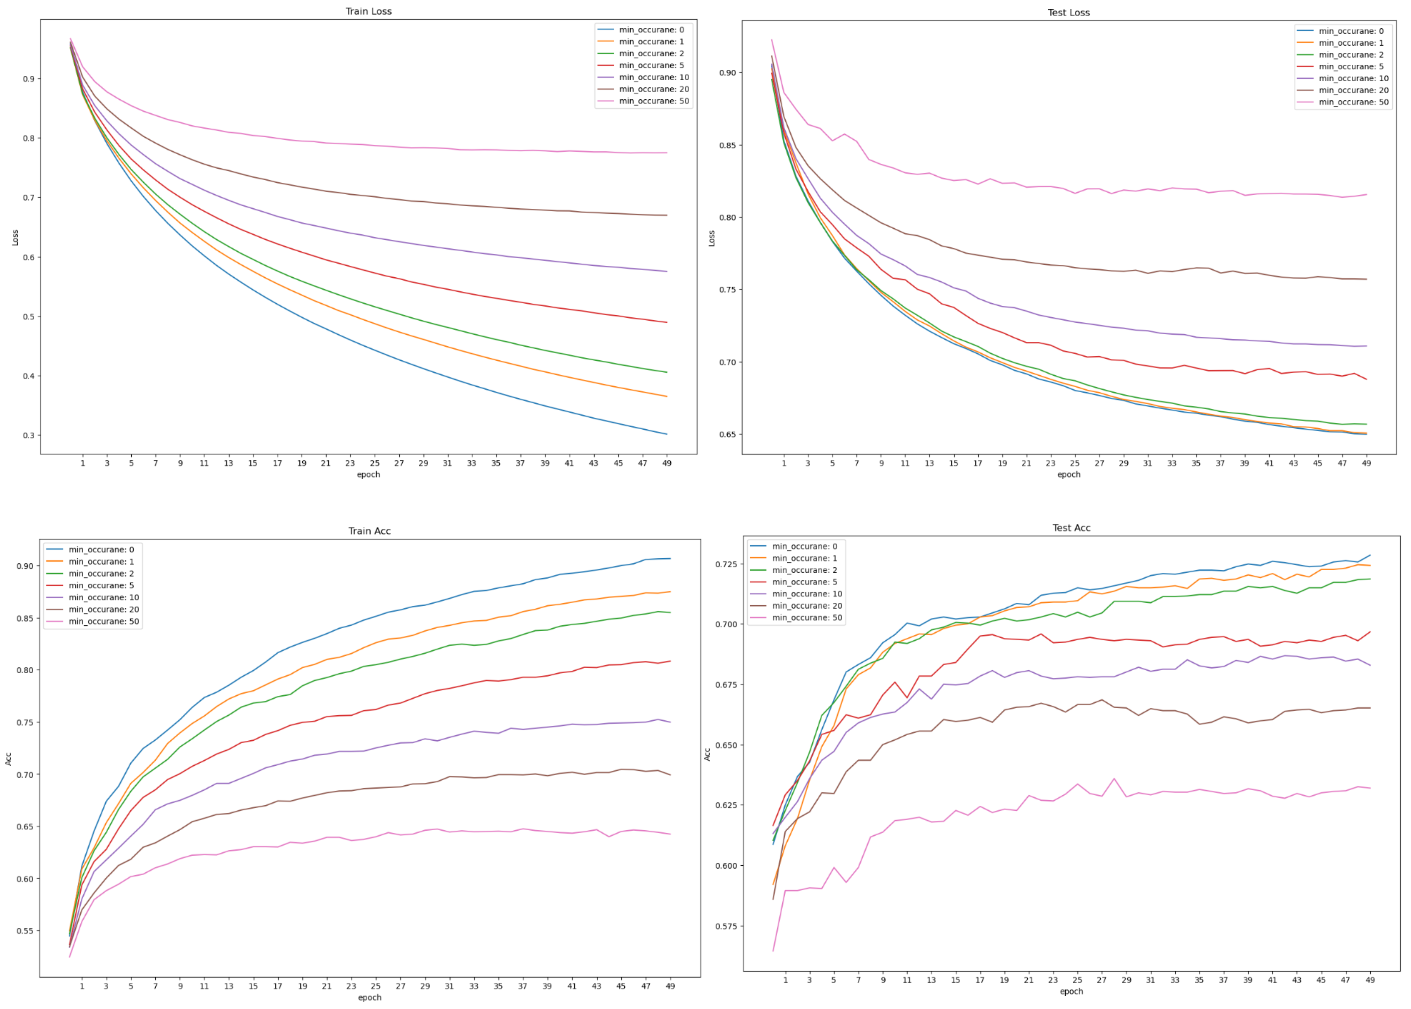  

<b>Observations</b>:  
1. Learning rate 0.5 is too small for the model to learn, the loss decreases slowly, and is no near to convergence after 50 epochs;
2. Although removing rare words is likely to improve model performance and to fight against overfitting, in our experiments, the more words removed, the worse the model gets, with slower convergence, higher loss and lower accuracy.  It is possible that since our data is originally not of a large scope, that some of the rare words actually speak out decisive features for the classification, rather than introducing in outliers or making the feature vector too sparse. Also, the removal might also make the weights for the “UNK” padding in the test samples too large, which also negatively affects the model prediction with low generalization ability.
3. Same reason as above, although machine learning results can be weakened by the “curse of high dimensionality”, since our original vocabulary is not of high dimension, the reduction of dimension(by removing rare words) does not improve the model behavior.  4. We will use the min_occurane=0 for later tuning, since it has the best prediction results on the test set.set.


#### 4.1.2 Momentum

We will enable the momentum calculation when updating the weights. The min_occurane to elminate vocabulary tokens is set to 0, which is the best performance in the above section. The learning rate and max epoch have the same configuration as Section 4.1.1, too.  

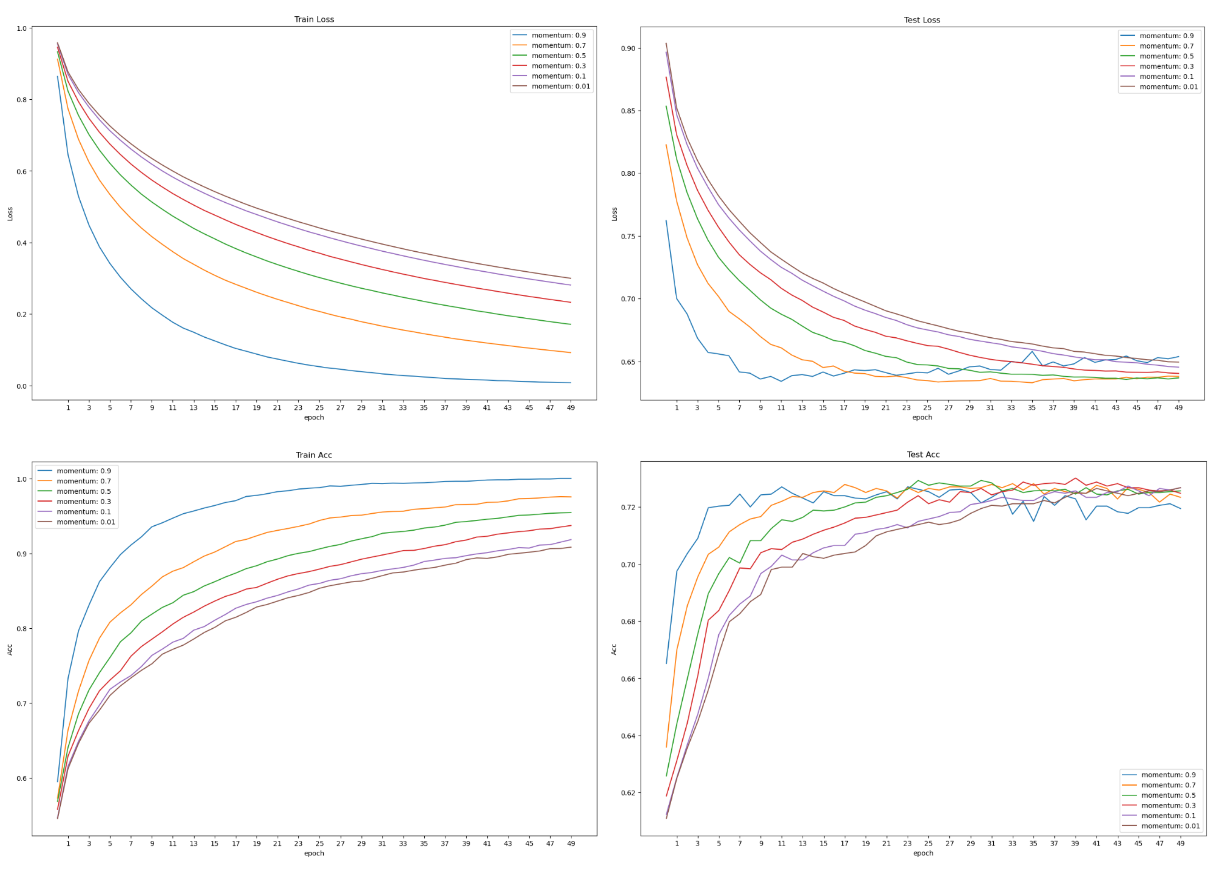  

<b>Observations:</b>
1. When the momentum is set to 0.9, the model updates its weight parameters too aggressively, which leads to overfitting quickly. Its loss curve fluctuates a lot on the test set, this is because the model updates too aggressively and always jumps around the optimal point.
2. The highest accuracy on the test set is with momentum 0.3. The accuracy curve and loss curve of momentum 0.1 approach to momentum 0.3 at the end of the epochs, and are still converging. Therefore, we will use momentum 0.1 and 0.3 for comparing learning rate.

#### 4.1.3 Learning Rate

There are in total three SGD optimizers we will test in this section:
1. SGD without momentum
2. SGD with momentum set to 0.3
3. SGD with momentum set to 0.1

Learning rates tested are: [0.01, 0.1, 0.3, 0.5, 0.9].  

<b>SGD without momentum</b>  
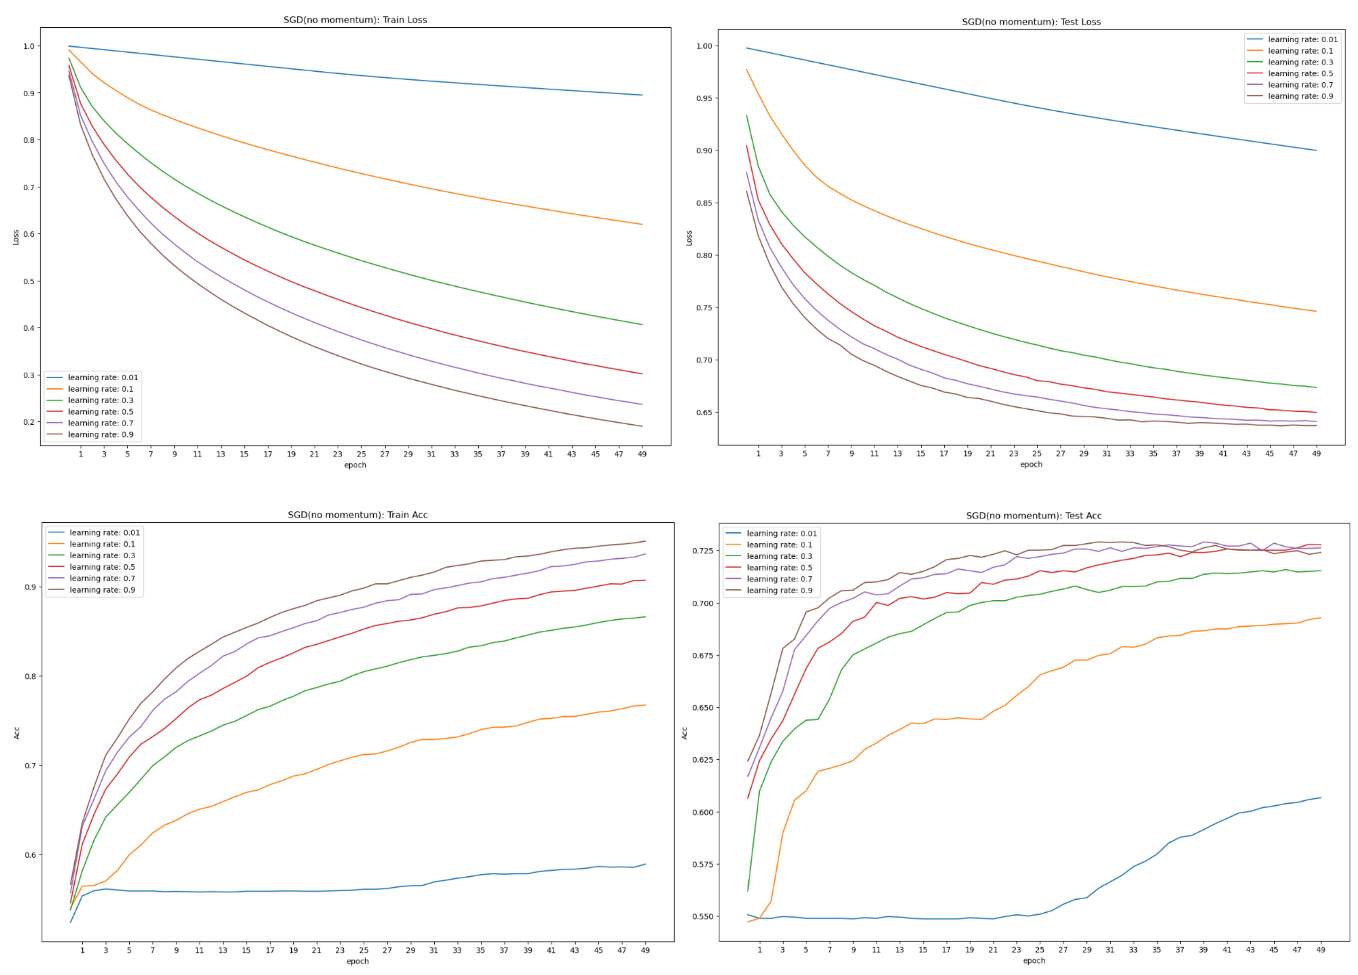  

<b>SGD with momentum=0.3</b>  
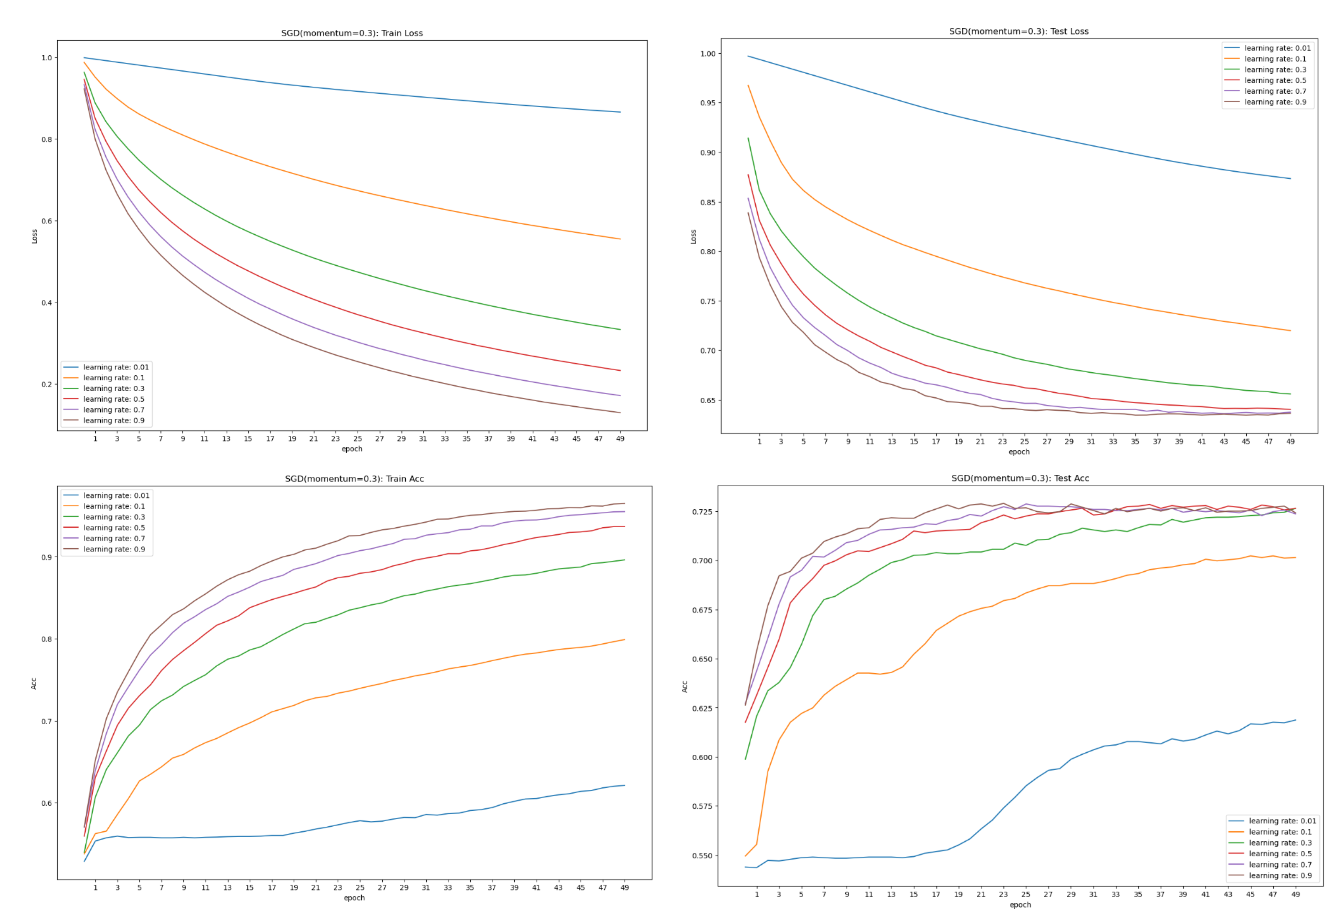  

<b>SGD with momentum=0.1</b>
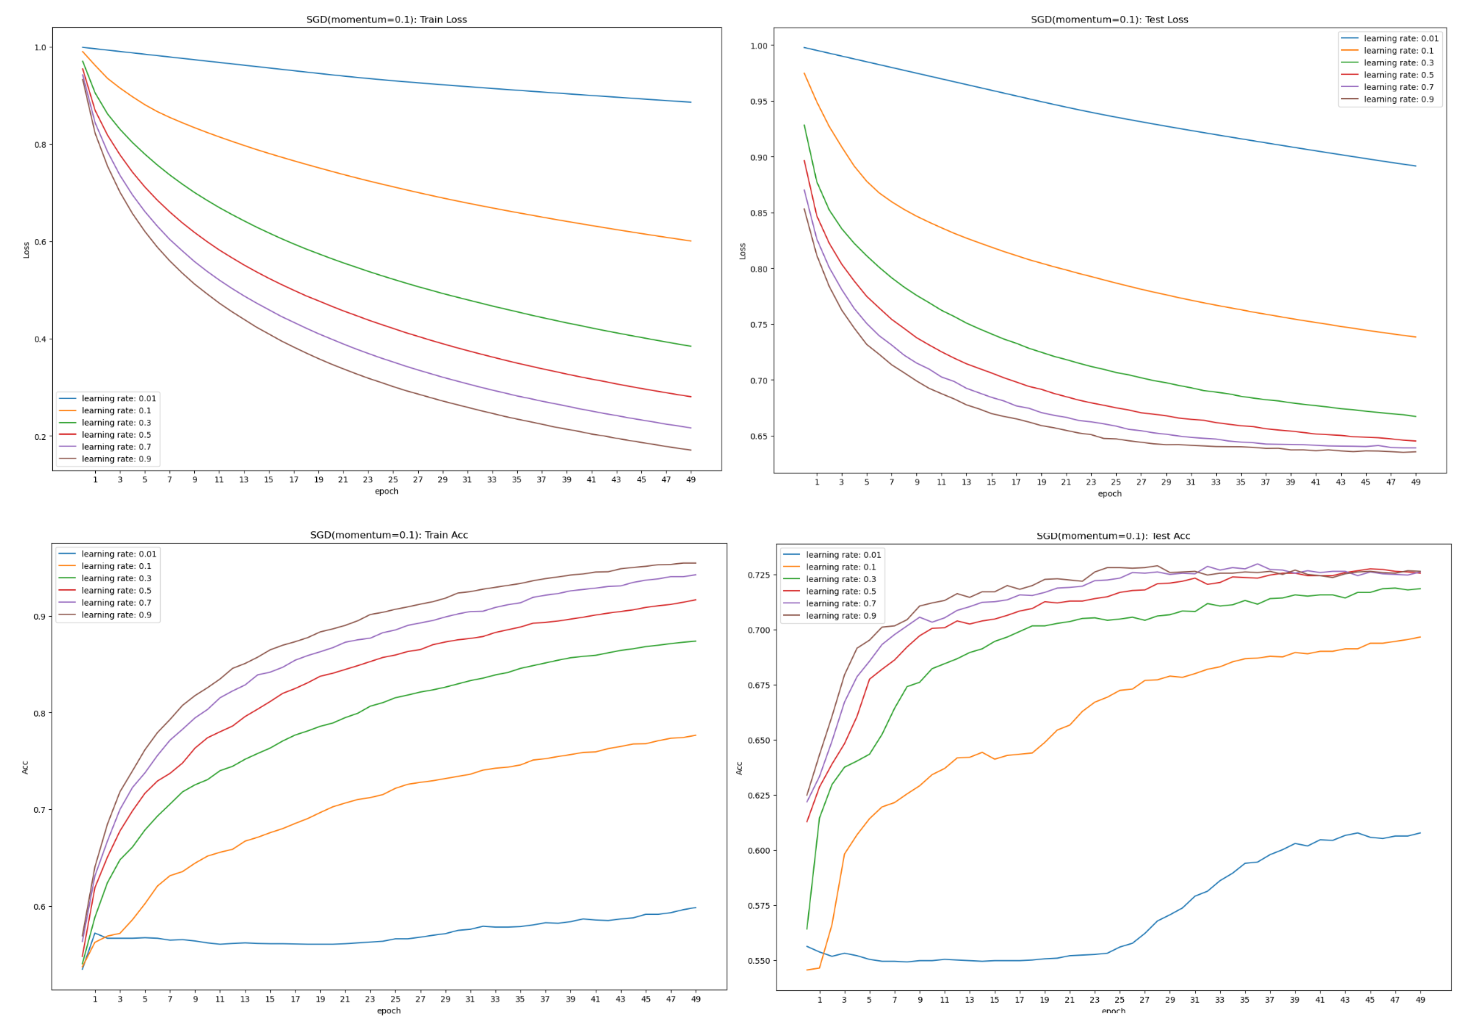  

<b>Observations:</b>
1. For all models we tested, the best performances are all with learning rate 0.9.
2. Models finished convergence at around 30 epochs.   

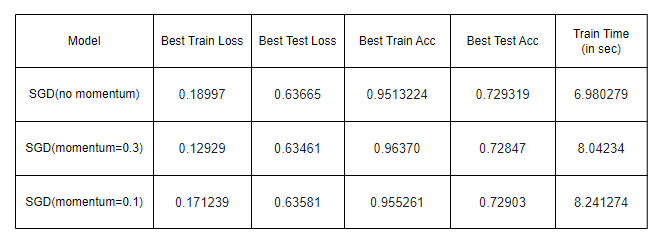  

With BOW model and word count to vectorize the textual data, learning rate 0.9 with momentum 0.1. The best test accuracy reaches 0.729(that is error 0.271).  

Due to the scope of our data set is not too large, keeping all the words extracted from the train samples in the vocabulary will not lead to weak generalization, or make the model less robust. But all in all, the generalization using BOW is not too ideal. The accuracy on the train set is above 0.95, whilst the best accuracy on the test set only hits around 0.73. The loss value also reflects the low generalization, with train loss below 0.2 and test loss above 0.6. This might be because: 1. Model tries to memorize too many rules from the train set, which does not apply to unknown data(test data); 2. The vocabulary is limited due to the scope of the train set, which makes the vector representations of test samples have large weight.  s 


### 4.2 N-grams
Parameters that could be adjusted in this section are:  

N-gram:  
* min_occurane, which affects the amount of features and the model capability on unknow tokens  
* character based or word based
* ngram size

Optimizer:  
* Learning Rate
* Whether apply momentum
* Momentum
* Max Epochs


#### 4.1.1 Word Based -- n

We will use learning rate 0.5 and max epoch 80 for a start.    

The n values tested are: [2], [3], [1,2], [1,3], [2,3]. And the associated feature dimensions are [46613, 66460, 58239, 78086, 114148].  

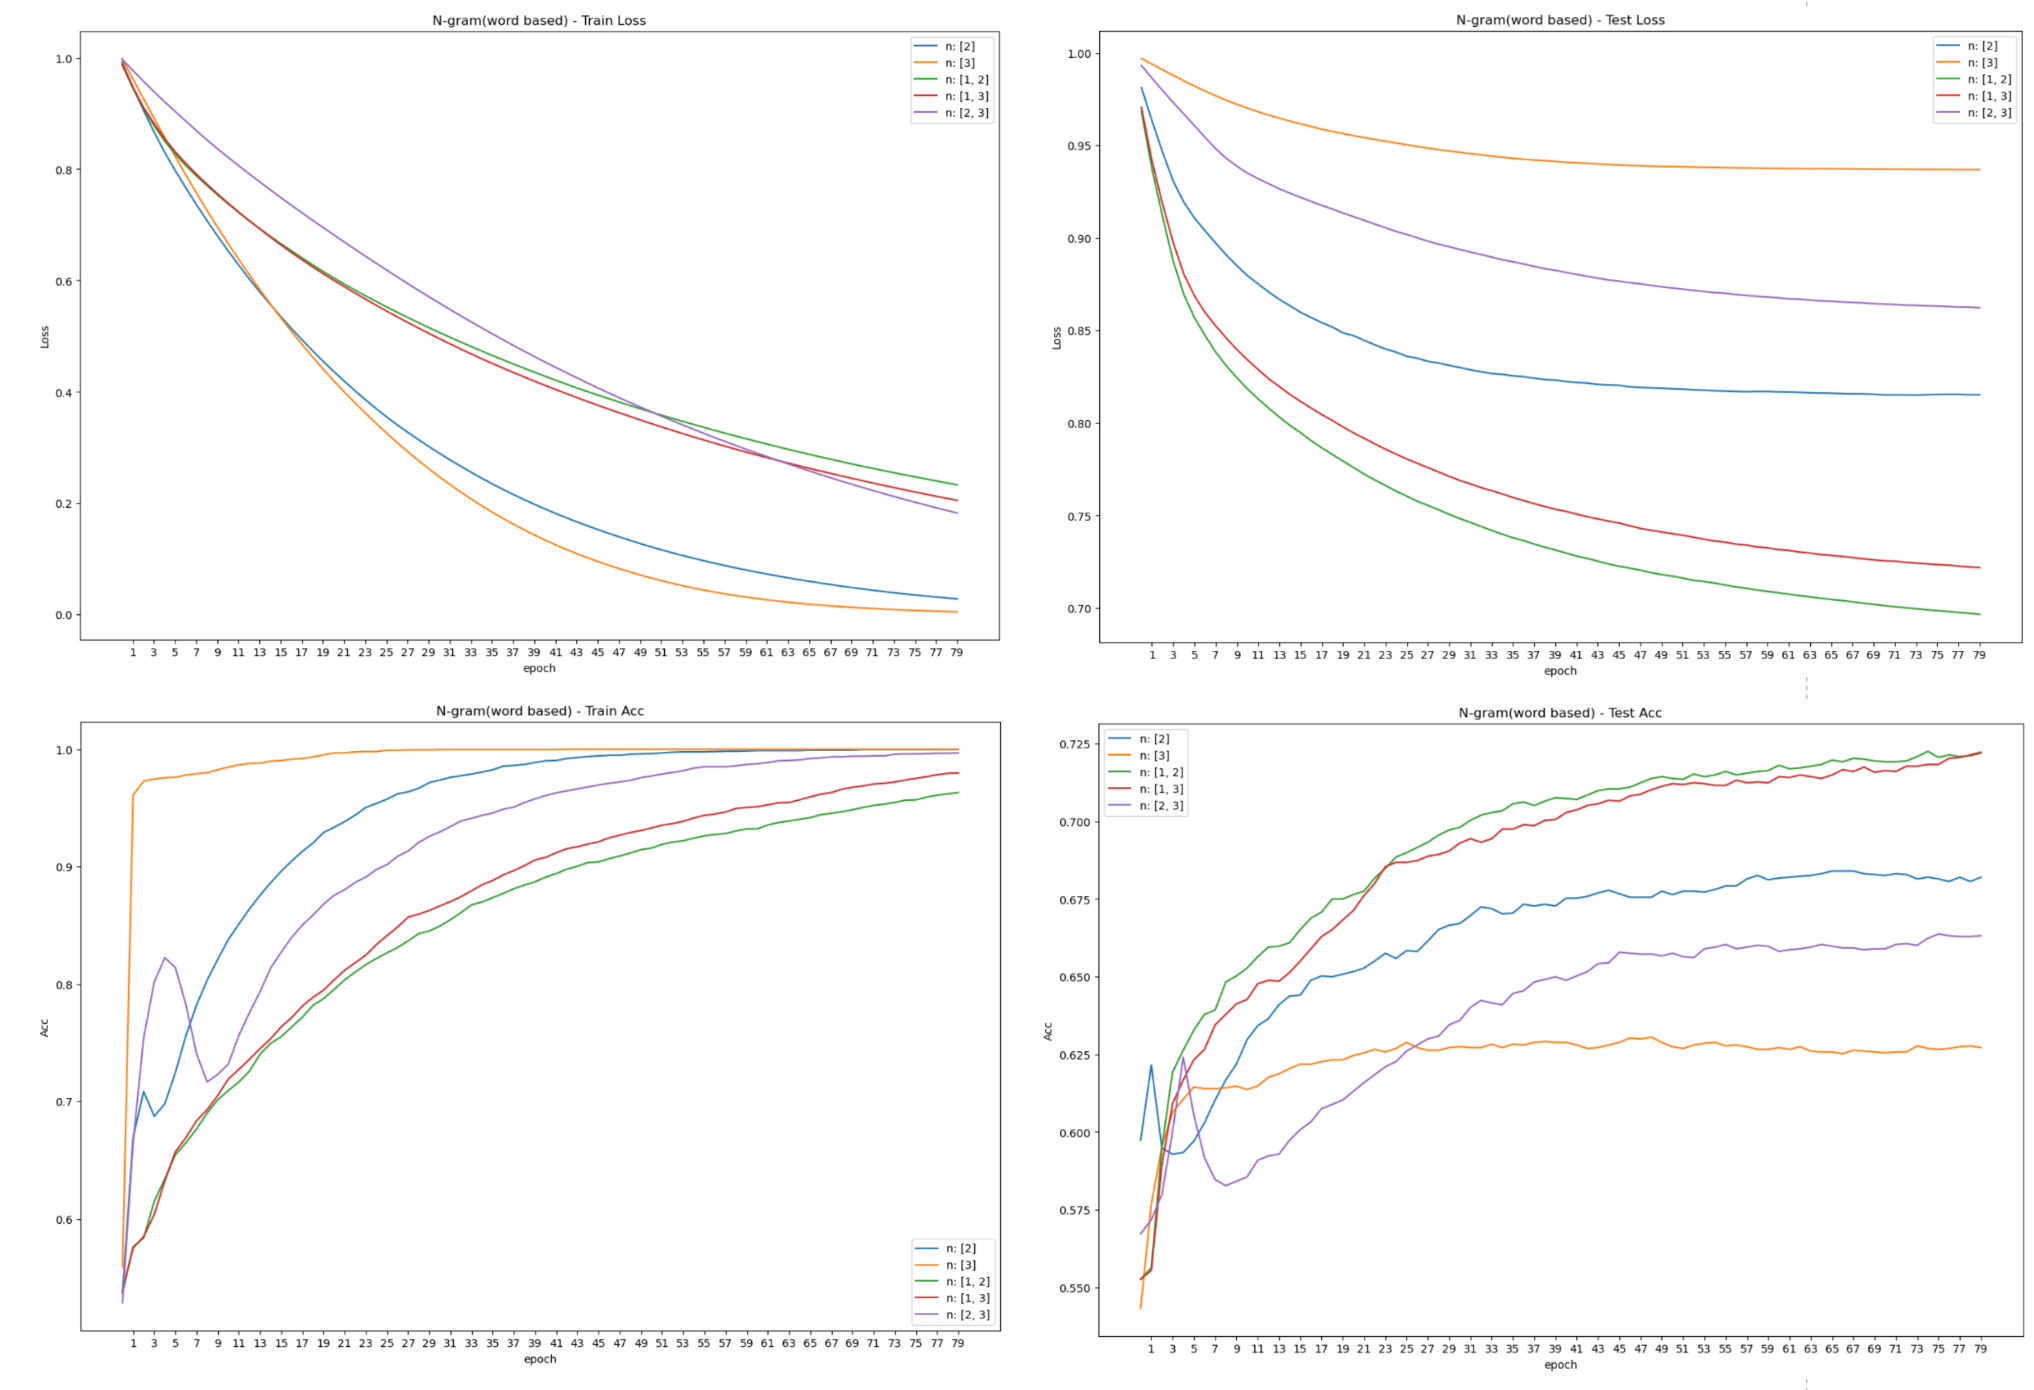  

<b>Observations:</b>
1. When the n for ngram is set to a single value, e.g. 2 or 3, the model has weak generalization ability. An assumption is that the single ngram(n not equal to 1) have comparatively small vocabulary, and that there exists many unseen adjacent pairs in the test samples. A language model can achieve low perplexity by choosing a small vocabulary and assigning the unknown word a high probability. Once mixing 1-gram with other ngrams, the model can be improved significantly.
2. The above assumption can also be proved by the model behavior with 2-gram and 3-gram, it is much worse than the combination of 1-gram with any other n-grams.
3. [1,2]-gram and [1,3] gram have the best performances among tested configurations. [1,2]-gram is slightly better with higher test accuracy and lower test loss.
4. Another phenomenon is that all models’ loss curves approach 0.0 and accuracies approach 1.0 at the end of the training. This might weaken the model generalization on unseen data. One possible reason is that the extracted feature vector is of too high of dimensionality.  

#### 4.1.2 Word Based -- min_occurane  

min_occuranes = [0, 1, 2, 5, 10, 30, 50]

For ngram n = [1,2], the dimension of vectorization is: [58239, 12552, 6567, 2501, 1130, 357, 193].  
For ngram n = [1,3], the dimension of vectorization is: [78086, 8697, 4368, 1667, 768, 262, 150].


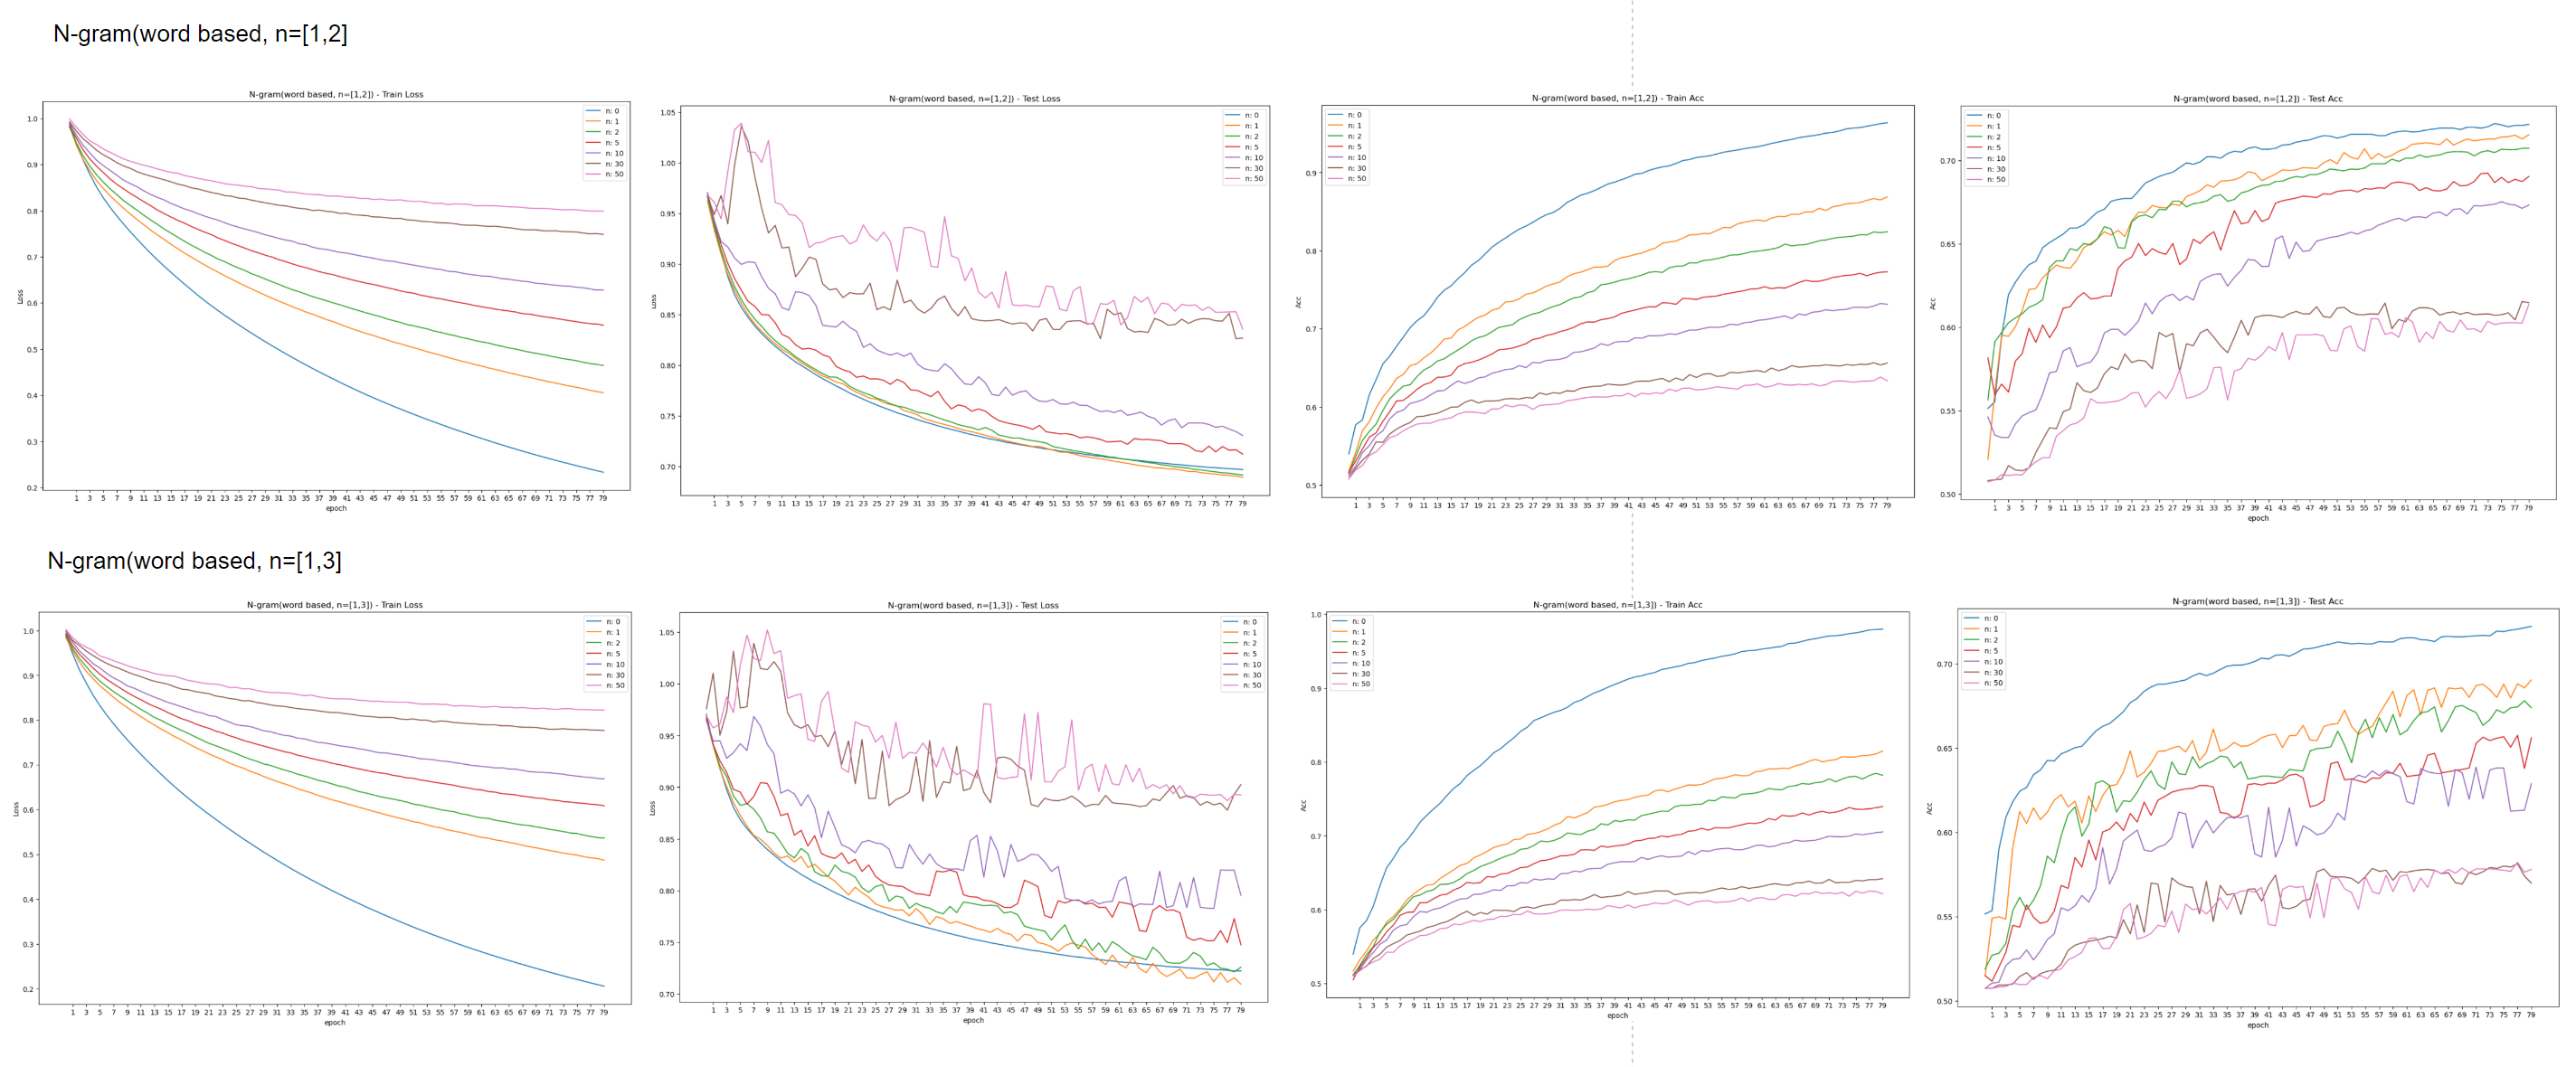  

<b>Observations:</b>
1. Both models have the worst predictions when the minimum count to keep a token in vocabulary is set to 30 or 50. When too many tokens are removed from the vocabulary, the vocabulary becomes too small and has not enough perplexity to represent the textual contents and the classification rules.
2. On the contrary to the assumption we made in the above section, the training loss approaches 0 and training accuracy approaches 1 is not caused by the impact of high dimensionality. Since in this section, the model has the best generalization ability when no tokens get removed from the vocabulary.
3. When using the combination of 1-gram and 2-gram, the result of minimum count 1 starts to approach minimum count 0 in the converging process. Therefore, we will test both configurations with other hyperparameters.
4. Curves on the test set fluctuate a lot with the combination of 1-gram and 3-gram. Reason for this is if the individual accuracy of a given n value is lower for a particular selected corpus size it has a slightly negative effect on combined feature selection accuracy. (larger the n larger can be the corpus size needed for improving a unit of accuracy).  

#### 4.1.3 Word Based -- Learning Rate

lrs = [0.9, 0.7, 0.5, 0.3, 0.1, 0.01]  

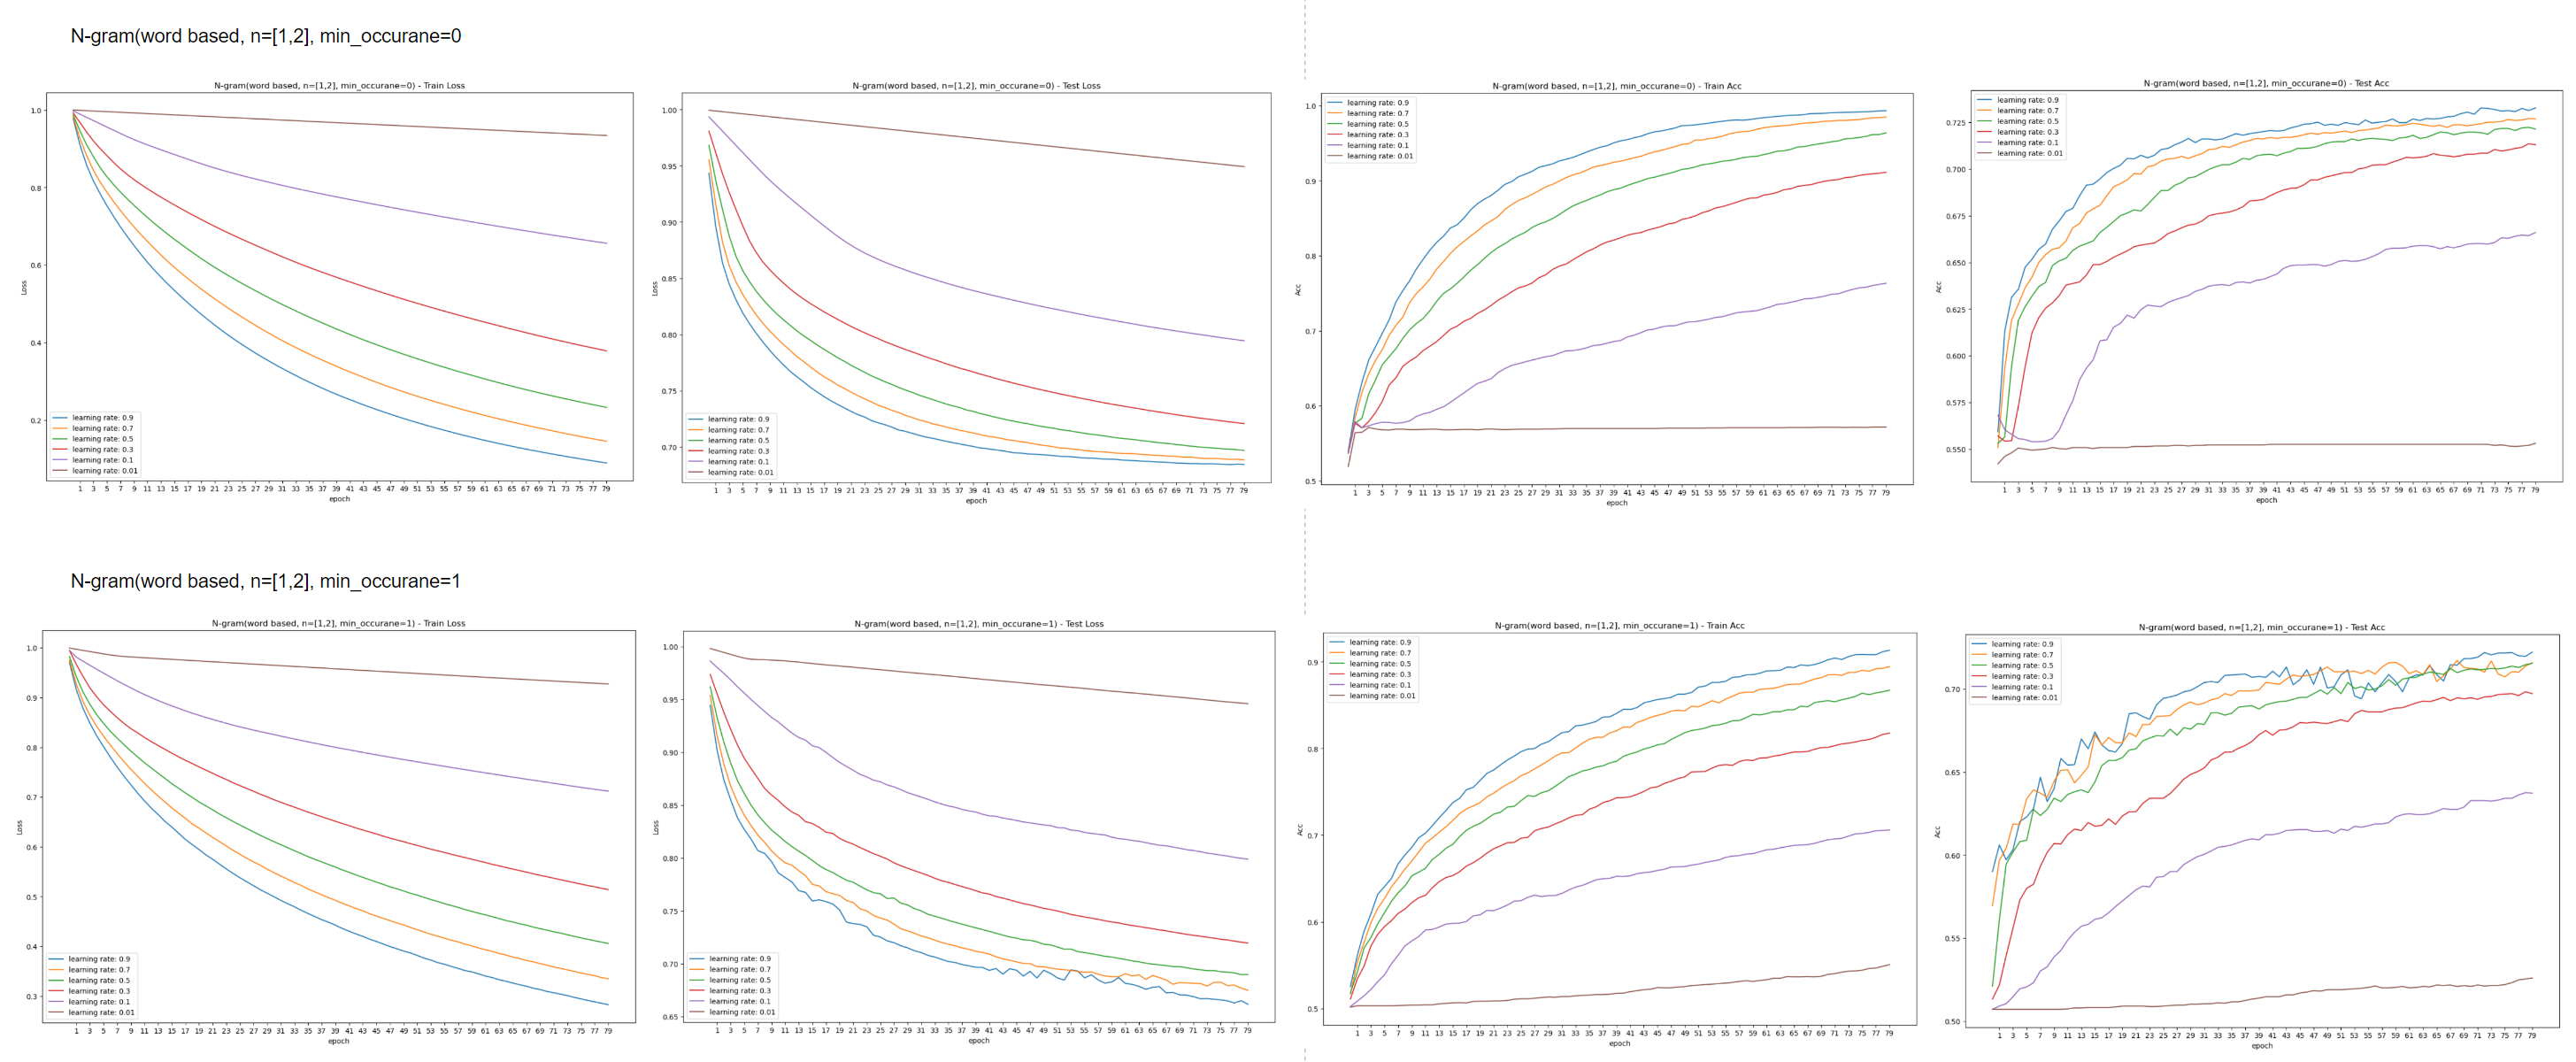  

<b>Observations:</b>
1. Models have their best performances when the learning rate is set to 0.9. In addition, none of the models with 0.9 learning rate has converged within 80 epochs. Therefore, we will introduce momentum to update the model more aggressively later for faster convergence.
2. As observed above, although the model behavior when removing tokens that only appear once is close to not removing any tokens, the minimum count 0 still has better prediction accuracy.  

#### 4.1.4 Word Based -- Momentum  

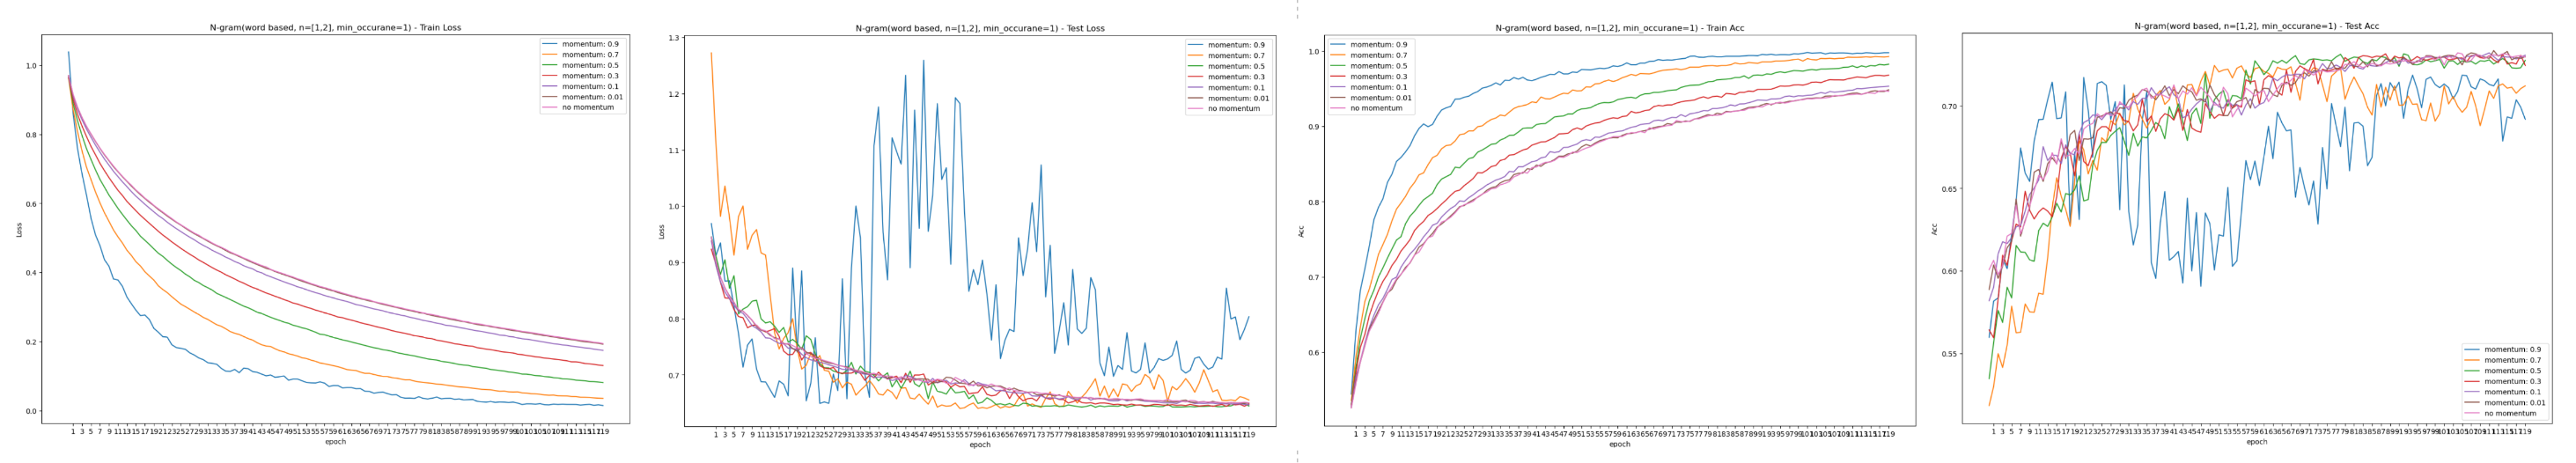  

<b>Onservations:</b>  
1. The Lowest quality of learning is when the momentum is set to 0.9. The parameter update is too aggressive, which leads to overfitting quickly. The loss and accuracy curves fluctuate a lot on the test set, this is because the model updates too aggressively and always jumps around the optimal point.
2. Overfitting also happens for momentum 0.7 and 0.5. Always having a large momentum can make the model jump around the global minimum since it updates too aggressively and can never actually reach the optimal solution point. It is recommended to have low momentum at the beginning of learning and increase it later to help the network converge more effectively. Momentum is a hyperparameter that helps accelerate gradient descent in the relevant direction and dampens oscillations. At the beginning of training, having low momentum allows the network to explore the parameter space more thoroughly, which can help it escape shallow local minima and prevent overshooting the global minimum. However, due to the time being not enough, we did not try Adam or other optimizers that decay the updates as the model converges.

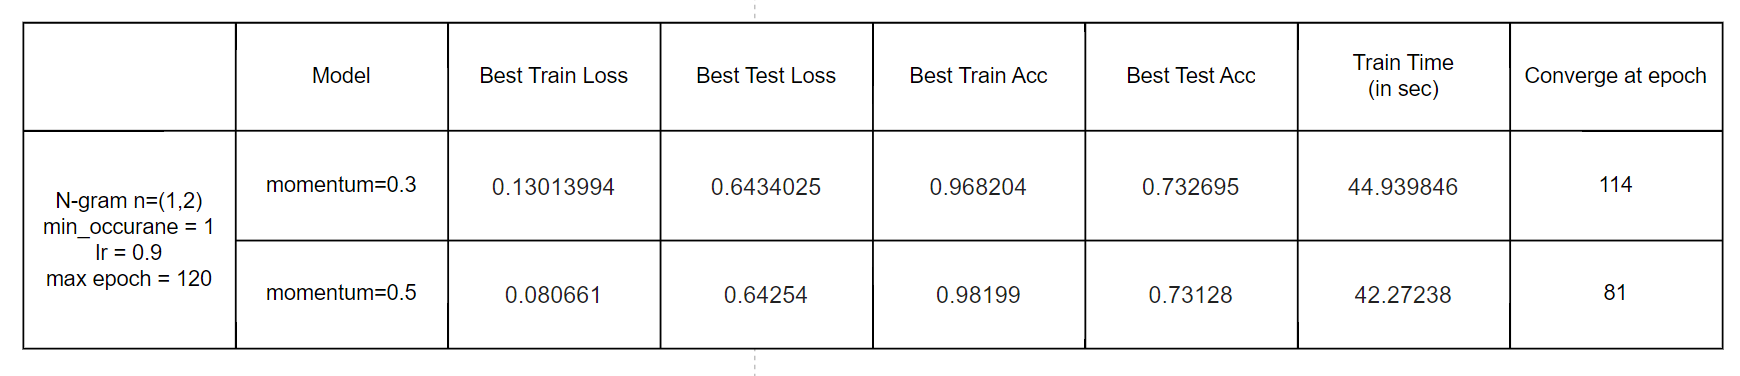  

The above is the final model configurations we choose for word-based ngram. We could see that the model performance is lower than the BOW. In n-grams, word order is important, whereas in BOW it is not important to maintain word order. During the NLP application, n-gram is used to consider words in their real order so we can get an idea about the context of the particular word; BOW is used to build vocabulary for your text dataset. And an assumption is that the word order and word-probability in regards to another word may not be that important to our task, and when most of our samples are only not-too-long sentences.  

#### 4.2.1 Character Based -- n    

ref: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8323729/    

All compared techniques for input vectors pre-processing required identical conditions. Therefore, the highest values of n in n-grams was determined as the first step. Most NLP tasks work usually with n = {1,2,3}. The higher value of n (4-grams, 5-grams, etc.) has significant demands on hardware and software, calculation time, and overall performance. On the other hand, the potential contribution of the higher n-grams in increasing the accuracy of created models is limited.  

Values for n-gram n tested are: [[1], [2], [3], [1,2], [1,3], [2,3], [3, 4], [1,2,3], [2,3,4]].  
Associaed feature dimensions: [137, 1058, 7670, 1136, 7748, 8669, 37167, 8747, 38166].   

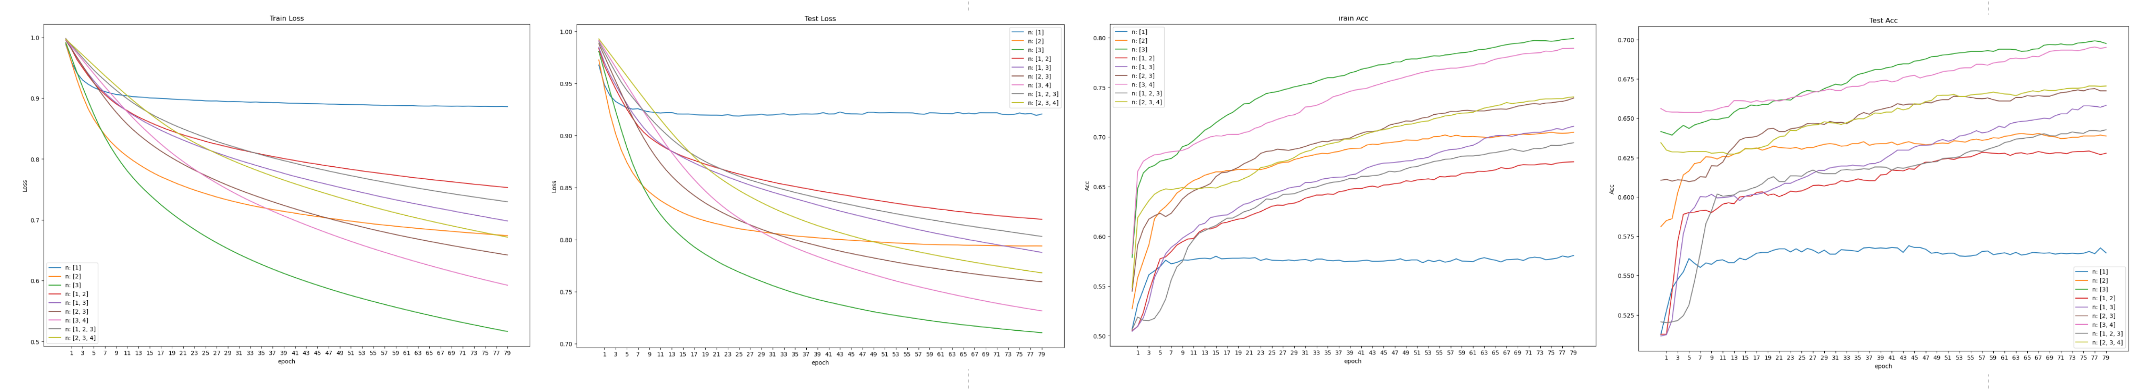  

The model has promising performances whren ngram is set to [3] or [3,4], We will use these two to tune minimum occurance.

#### 4.2.2 Character Based -- min_occurane

The min_occurance values we tested are: [0, 1, 2, 5, 10, 30, 50, 100].  
Associated feature dimensions are:  
* ngram=[3]: [7670, 5851, 5091, 3970, 3130, 1952, 1473, 902]
* ngram=[3,4]: [37167, 25032, 20365, 13979, 9873, 4745, 3055, 1549]  

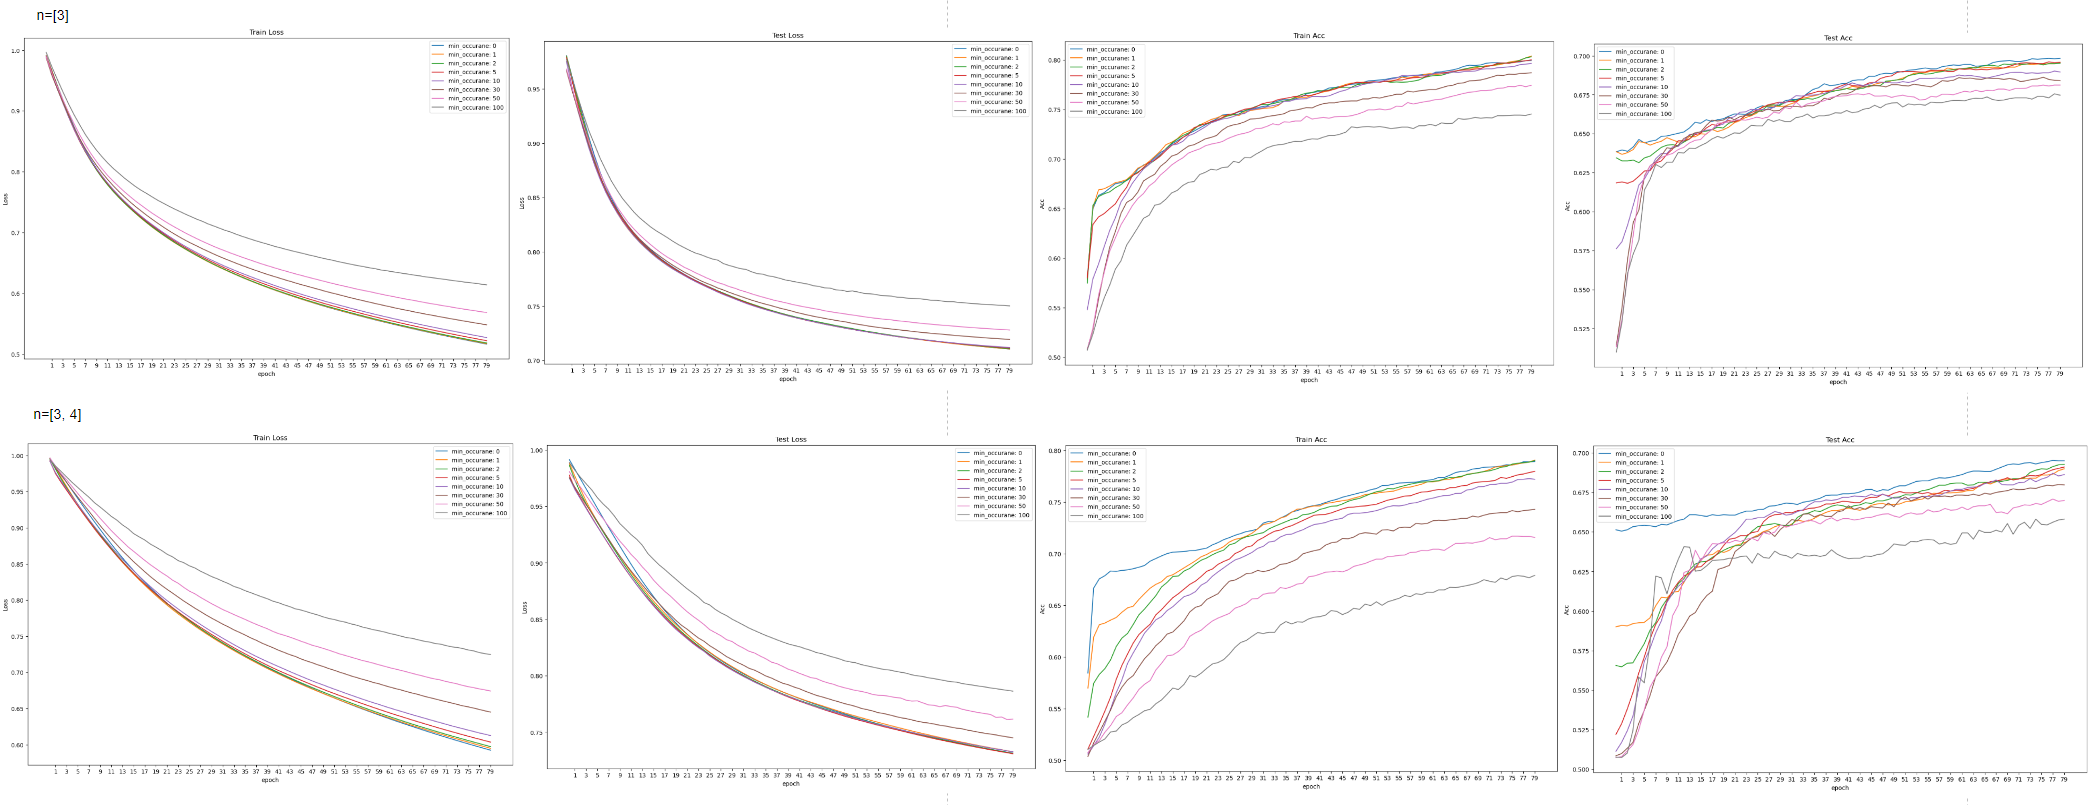  

The model has the highest accuracy on the test set when the min_occurane is set to 0, that is, not removing any extracted ngram tokens. 

#### 4.2.3 Character Based -- Learnig Rate

We could see from the above diagram, none of the models finished convergence with learning rate 0.5 within 80 epochs. This suggests that 0.5 is still too small for the learning process. We will test higher learning rate values in this section.  

<b>Min Occurane = 0</b>  
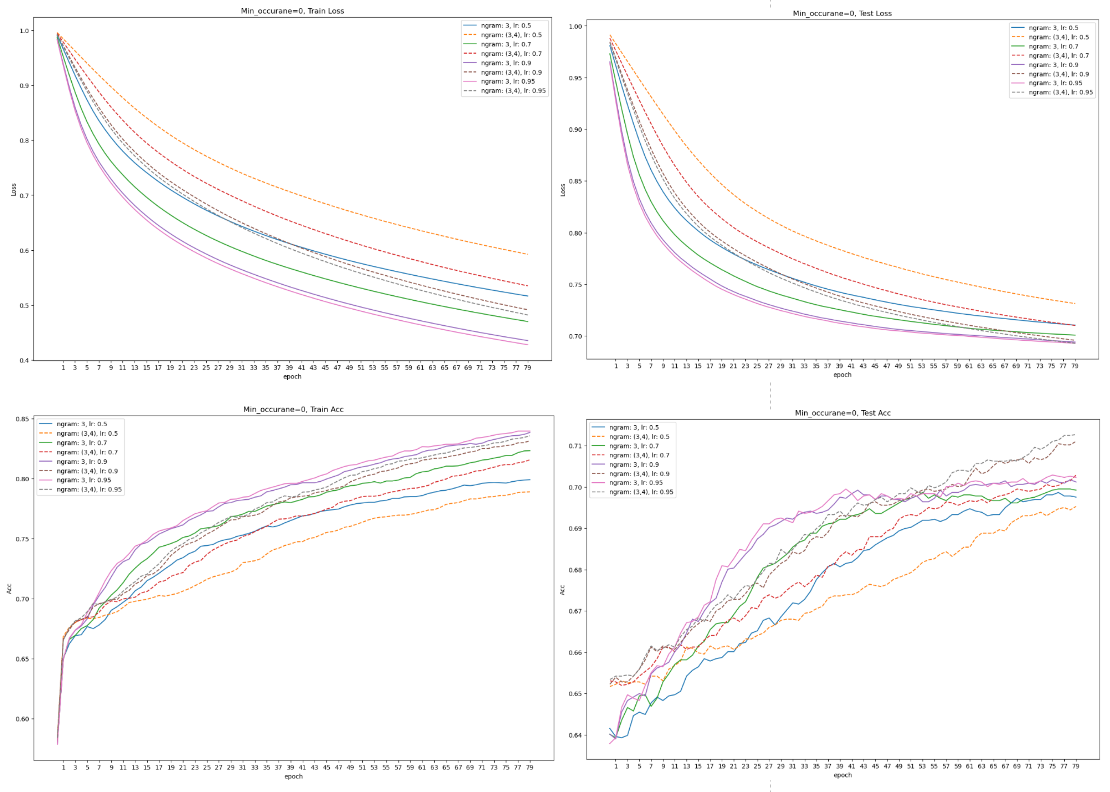  

When the ngram is [3,4], the model has the best generalization ability on the test set. The model has the fastest converging speed with learning rate 0.95, ans is still converging at the last epoch.

#### 4.2.4 Character Based -- Momentum

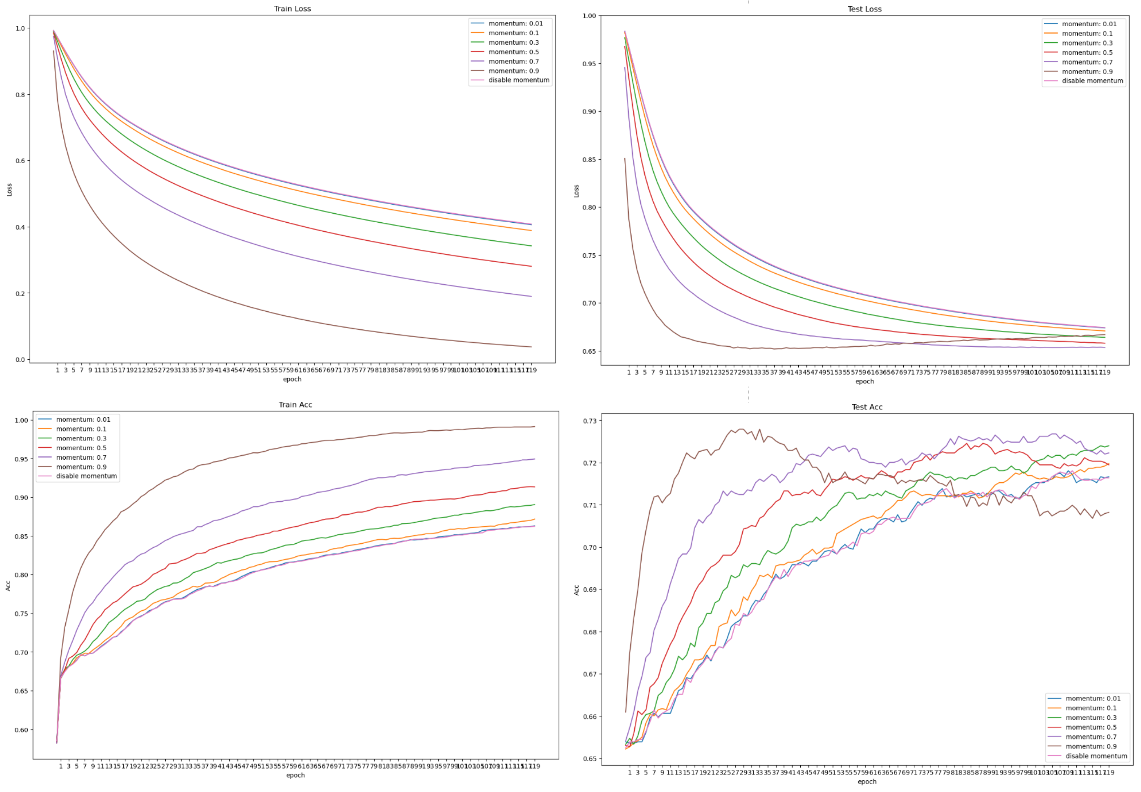  

The highest test accuracy scores and lowest test losses are with:
1. momentum = 0.9
2. momentum = 0.7  
However, when the momentum is set to 0.9, the model updates the weight too aggressively, and overfitting happens at around 30 epoch. 

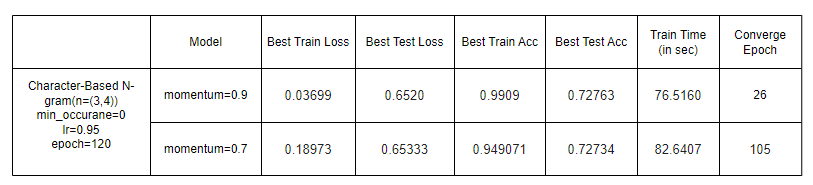  

Compared to the word based n gram in Section 5.2, the best accuracy scores on the test set from byte-based n gram is lower. The byte based n gram has a smaller vocabulary, since the combination of letters are more limited. This also suggests that byte-based n grams hold much less information.  They are usually utilized in such tasks as language identification, writer identification (i.e. fingerprinting), anomaly detection. In addition, byte-based n-grams converge faster than word-based ones.  The limited information and dimension leads to easy-overfitting and low generalization.


### 4.3 Gensim Pretrained Models

#### 4.3.1 Pretrained Models

Based on the experiences from above experiments, we will use SGD with no momentum and learning rate 0.5 for a start. We will iterate 50 epochs.  
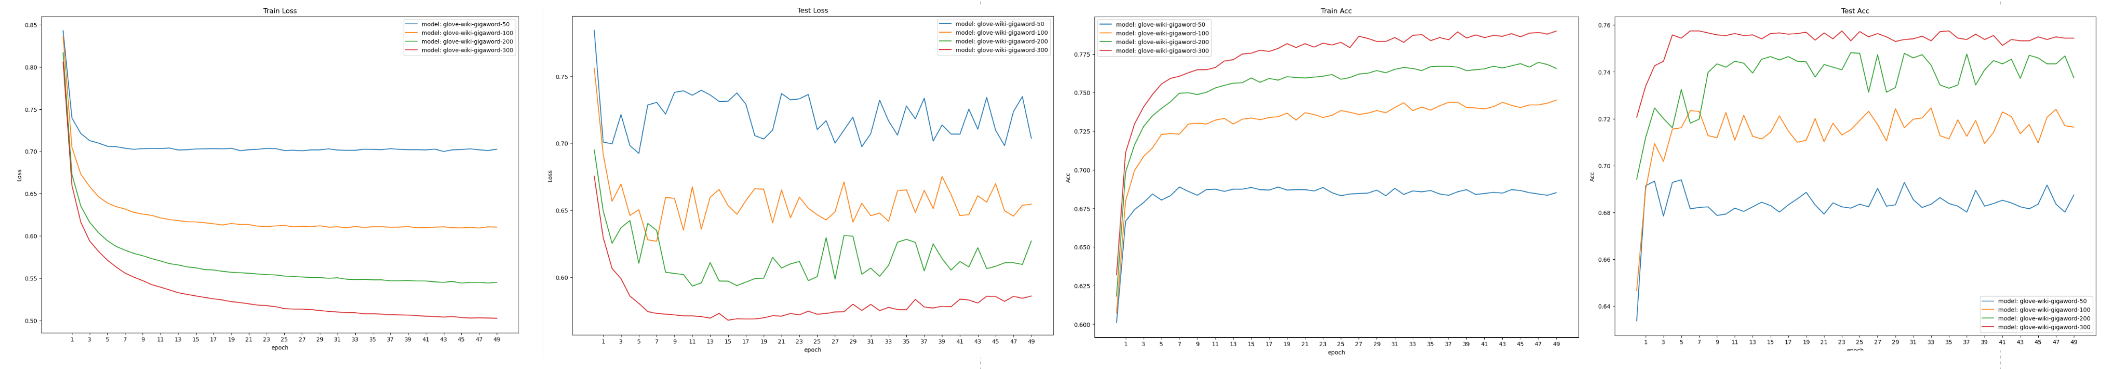  

<b>Observations:</b>  
1. When we use a pretrained model that embed the vectorization to 300 dimensions, the classification has the best accuracy scores on the test set. We will use "glove-wiki-gigaword-300" for later experiments.
2. Using pretrained models makes the classifier converge faster. Classifiers all overfit with different pretrained models. In later sections, we could either decrease the epoch amount, or to lower the learning rate.  

#### 4.3.2 Learnig Rate
From Section 4.3.1, we could notice that the model overfits before the 20th epoch. This suggests that learning rate 0.5 updates the model too aggressively. Therefore, we will mainly compare the model performances with lower learning rate

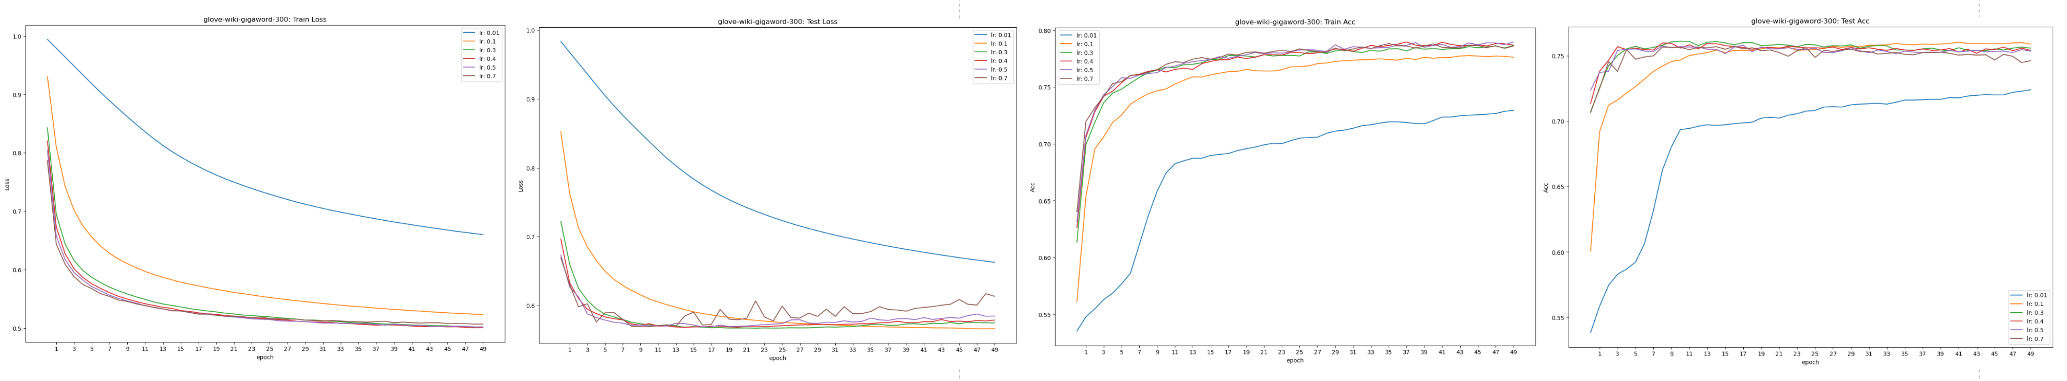  

<b>Observations:</b>  
1. Learning rate 0.01 is too small for our model to learn. Learning rate 0.7 leads to overfitting quickly.
2. Learning rates 0.1, 0.3, 0.4 and 0.5 are more suitable to our task and data, among which learning rate 0.1 has the best performances.  

#### 4.3.3 Momentum

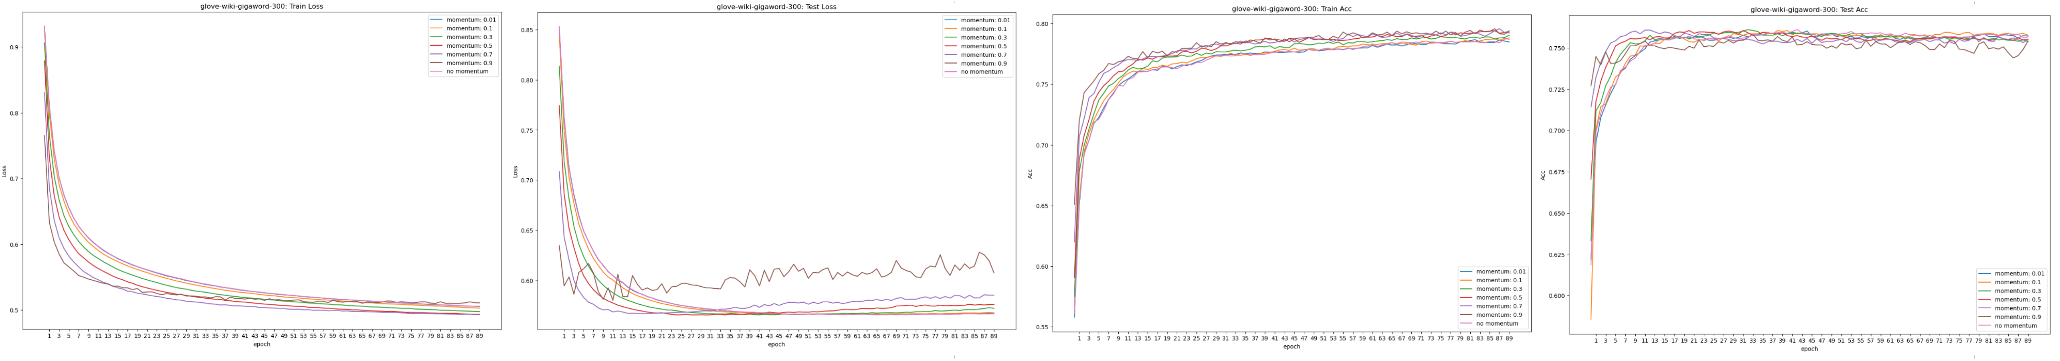  

Since the model converges and overfits fast in the previous sections, we know that using this pretrained model should avoid aggressive updates. The learning curves also suggest this. With momentum set to 0.9, the model overfits before finishing the first 20 epochs.

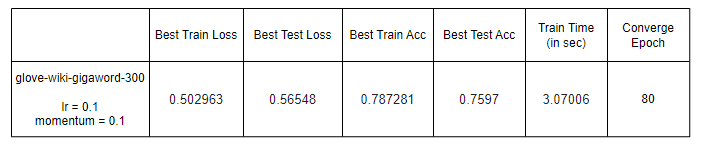

## Appendix

Below are code snippets for batch testing hyperparameters.

In [35]:
model = 'glove-wiki-gigaword-300'
pretrain_model = api.load(model)
momentum = 0.1

all_train_loss, all_train_acc, all_train_time, all_test_loss, all_test_acc = [], [], [], [], []

# get the features
x_train = []
y_train = []
x_test = []
y_test = []
for (line, label) in train_data:
    x_train.append(pretrain_extract_features(line, pretrain_model))
    y_train.append(label)
for (line, label) in test_data:
    x_test.append(pretrain_extract_features(line, pretrain_model))
    y_test.append(label)
# cast to numpy array
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# training
model = HingeLoss(x_train.shape[1], 1)
optimizer = SGD(lr, momentum, True)
train_loss, train_acc, train_time, test_loss, test_acc = train(model, optimizer, 90, x_train, y_train, x_test, y_test)
# log the training loss and acc for later visualization
all_train_loss.append(train_loss)
all_train_acc.append(train_acc)
all_train_time.append(train_time)
all_test_loss.append(test_loss)
all_test_acc.append(test_acc)

    

In [36]:
min(train_loss), min(test_loss), max(train_acc), max(test_acc), train_time

(0.5029632344711612,
 0.5654819876791319,
 0.7872819358469331,
 0.7597073719752392,
 3.070061206817627)

In [37]:
a = max(test_acc)
test_acc.index(a)

80

Text(0.5, 1.0, 'glove-wiki-gigaword-300: Test Acc')

<Figure size 640x480 with 0 Axes>

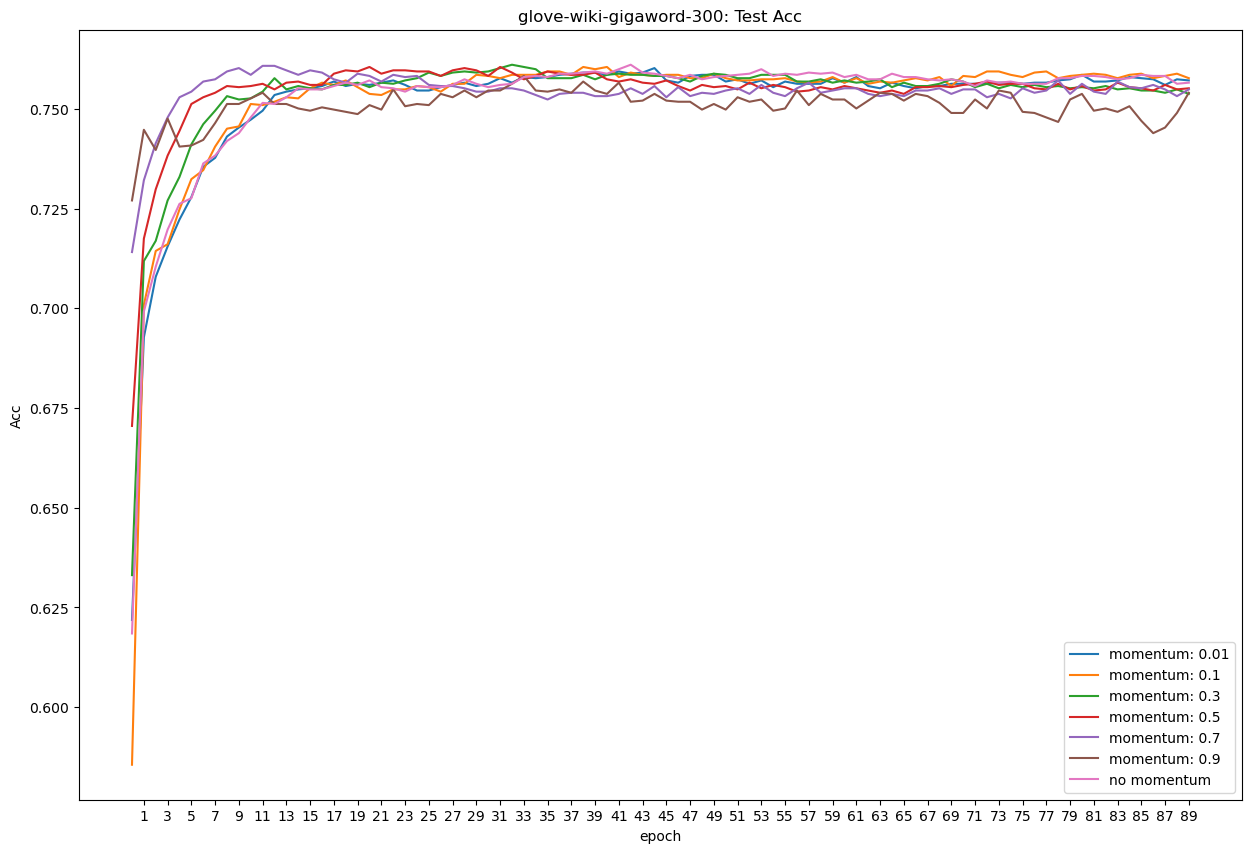

In [34]:
plt.figure()
plt.figure(figsize=(15, 10))
x = [i for i in range(90)]
# draw epoch accuracy and loss
plt.xticks(np.arange(1,90,step=2))

for i in range(len(momentums)):
    plt.plot(x, all_test_acc[i], linestyle='-', label='momentum: {}'.format(momentums[i]))
plt.plot(x, all_test_acc[-1], linestyle='-', label='no momentum')
    
plt.legend()
plt.xlabel('epoch')
plt.ylabel("Acc")
plt.title("glove-wiki-gigaword-300: Test Acc")

In [75]:
min_occurane = 0
ngram = [3, 4]

vocab = build_ngrams(train_data, ngram=ngram, min_occurane=min_occurane, byte_base=True)
x_train = []
y_train = []
x_test = []
y_test = []
for (line, label) in train_data:
    x_train.append(Ngram_feature_extract(line, vocab, ngram, True))
    y_train.append(label)
for (line, label) in test_data:
    x_test.append(Ngram_feature_extract(line, vocab, ngram, True))
    y_test.append(label)
# cast to numpy array
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)